# IMDB Reviews Text Classification

Este notebook explora classificadores Random Forest e SVM para classificar avaliações do IMDB usando representações de frequência de uni-gramas.

In [2]:
# 1. Configuração de diretórios e importações
import os
import glob
import collections
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Defina o diretório base do dataset
DATA_DIR = "./aclImdb"
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')


In [3]:
# 2. Carregamento dos dados e amostragem de 10%
from sklearn.model_selection import train_test_split

def load_data(base_dir):
    texts, labels = [], []
    # percorre apenas 'neg' e 'pos'
    for sentiment in ('neg', 'pos'):
        folder = os.path.join(base_dir, sentiment)
        for filepath in glob.glob(os.path.join(folder, '*.txt')):
            filename = os.path.basename(filepath)
            try:
                label = int(filename.split('_')[1].split('.')[0])
            except:
                continue

            with open(filepath, 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(label)
    return texts, labels

X_train_full, y_train_full = load_data(TRAIN_DIR)
X_test_full, y_test_full = load_data(TEST_DIR)

# Amostragem aleatória de 10% dos dados
# X_train, _, y_train, _ = train_test_split(
#     X_train_full, y_train_full, train_size=0.3, random_state=42, stratify=y_train_full
# )
# X_test, _, y_test, _ = train_test_split(
#     X_test_full, y_test_full, train_size=0.3, random_state=42, stratify=y_test_full
# )
X_train, y_train = X_train_full, y_train_full
X_test, y_test = X_test_full, y_test_full

# Análise de distribuição de classes
counter = collections.Counter(y_train)
print("Distribuição de classes no treino (100%):", counter)
minority_class = min(counter, key=counter.get)
print("Classe minoritária identificada:", minority_class)


Distribuição de classes no treino (100%): Counter({1: 5100, 10: 4732, 8: 3009, 4: 2696, 7: 2496, 3: 2420, 2: 2284, 9: 2263})
Classe minoritária identificada: 9


In [4]:
# 3. Vetorização - Frequência de uni-gramas
vectorizer = CountVectorizer(ngram_range=(1,1), lowercase=True)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("Número de features (uni-gramas):", X_train_vec.shape[1])


Número de features (uni-gramas): 74849


RF Accuracy: 0.3638


/Users/cassi/dev/uni/tai/classifiers/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RF  | Accuracy: 0.3638, Precision (macro): 0.3173, Recall (macro): 0.2403, F1 (macro): 0.1757
SVM | Accuracy: 0.3271, Precision (macro): 0.2735, Recall (macro): 0.2751, F1 (macro): 0.2741


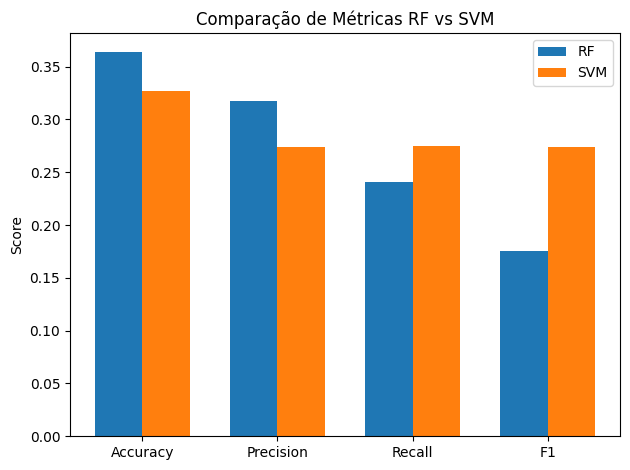

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# 4. Treinamento e Avaliação dos Modelos

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_vec, y_train)
y_pred_rf = rf.predict(X_test_vec)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"RF Accuracy: {acc_rf:.4f}")

# SVM (Linear)
svm = LinearSVC(random_state=42, max_iter=10000)
svm.fit(X_train_vec, y_train)
y_pred_svm = svm.predict(X_test_vec)

# Cálculo das métricas macro
acc_rf  = accuracy_score(y_test, y_pred_rf)
prec_rf, rec_rf, f1_rf, _ = precision_recall_fscore_support(
    y_test, y_pred_rf, average='macro', zero_division=0)
acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm, rec_svm, f1_svm, _ = precision_recall_fscore_support(
    y_test, y_pred_svm, average='macro', zero_division=0)

print(f"RF  | Accuracy: {acc_rf:.4f}, Precision (macro): {prec_rf:.4f}, Recall (macro): {rec_rf:.4f}, F1 (macro): {f1_rf:.4f}")
print(f"SVM | Accuracy: {acc_svm:.4f}, Precision (macro): {prec_svm:.4f}, Recall (macro): {rec_svm:.4f}, F1 (macro): {f1_svm:.4f}")

# Gráfico comparativo RF vs SVM
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
rf_scores  = [acc_rf,  prec_rf,  rec_rf,  f1_rf]
svm_scores = [acc_svm, prec_svm, rec_svm, f1_svm]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, rf_scores,  width, label='RF')
ax.bar(x + width/2, svm_scores, width, label='SVM')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_title('Comparação de Métricas RF vs SVM')
ax.legend()
plt.tight_layout()
plt.show()


Classe 9 - RF  | Precision: 0.2692, Recall: 0.0060, F1: 0.0117
Classe 9 - SVM | Precision: 0.1689, Recall: 0.1553, F1: 0.1618


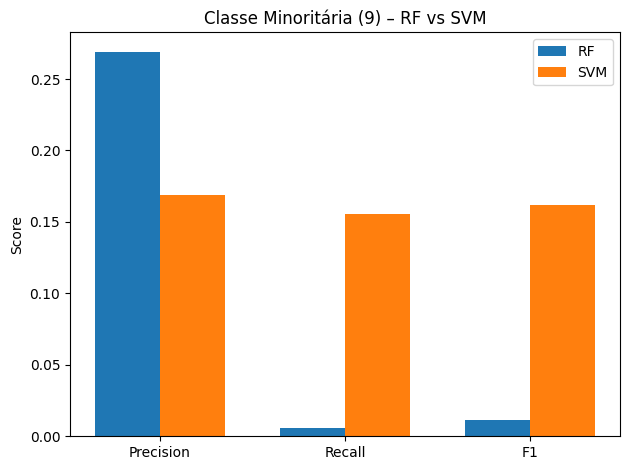

In [6]:
# 5. Métricas para a classe minoritária com gráfico comparativo
from sklearn.metrics import precision_recall_fscore_support

# Binariza: 1 = minority_class, 0 = demais
y_test_bin     = [1 if y==minority_class else 0 for y in y_test]
y_pred_rf_bin  = [1 if y==minority_class else 0 for y in y_pred_rf]
y_pred_svm_bin = [1 if y==minority_class else 0 for y in y_pred_svm]

# Cálculo das métricas binárias
prec_rf_m, rec_rf_m, f1_rf_m, _ = precision_recall_fscore_support(
    y_test_bin, y_pred_rf_bin, average='binary', zero_division=0)
prec_svm_m, rec_svm_m, f1_svm_m, _ = precision_recall_fscore_support(
    y_test_bin, y_pred_svm_bin, average='binary', zero_division=0)

print(f"Classe {minority_class} - RF  | Precision: {prec_rf_m:.4f}, Recall: {rec_rf_m:.4f}, F1: {f1_rf_m:.4f}")
print(f"Classe {minority_class} - SVM | Precision: {prec_svm_m:.4f}, Recall: {rec_svm_m:.4f}, F1: {f1_svm_m:.4f}")

# Gráfico comparativo de métricas para a classe minoritária
metrics_min = ['Precision', 'Recall', 'F1']
rf_min_scores  = [prec_rf_m, rec_rf_m, f1_rf_m]
svm_min_scores = [prec_svm_m, rec_svm_m, f1_svm_m]

x = np.arange(len(metrics_min))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, rf_min_scores,  width, label='RF')
ax.bar(x + width/2, svm_min_scores, width, label='SVM')
ax.set_xticks(x)
ax.set_xticklabels(metrics_min)
ax.set_ylabel('Score')
ax.set_title(f'Classe Minoritária ({minority_class}) – RF vs SVM')
ax.legend()
plt.tight_layout()
plt.show()



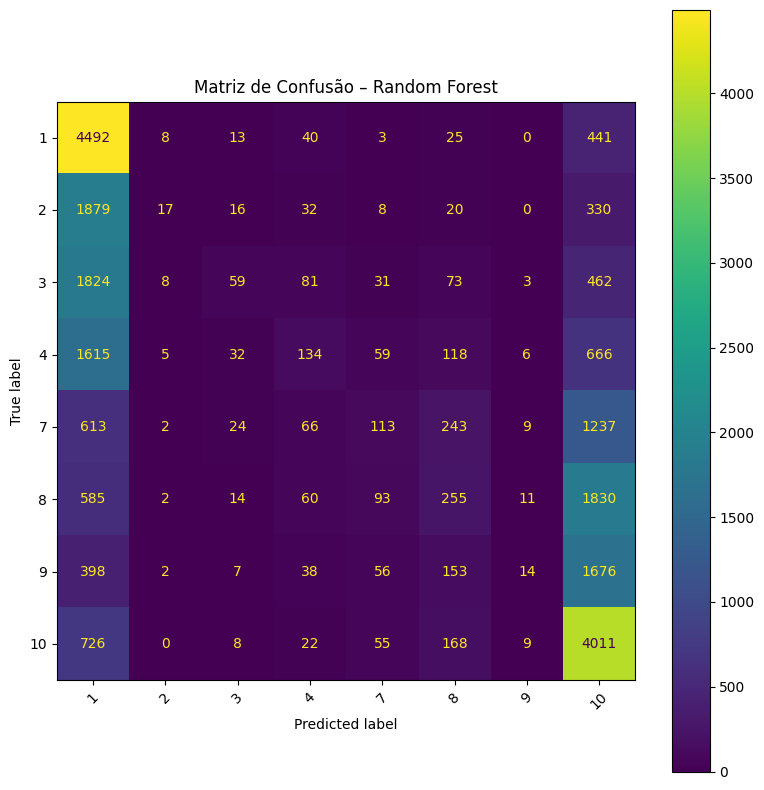

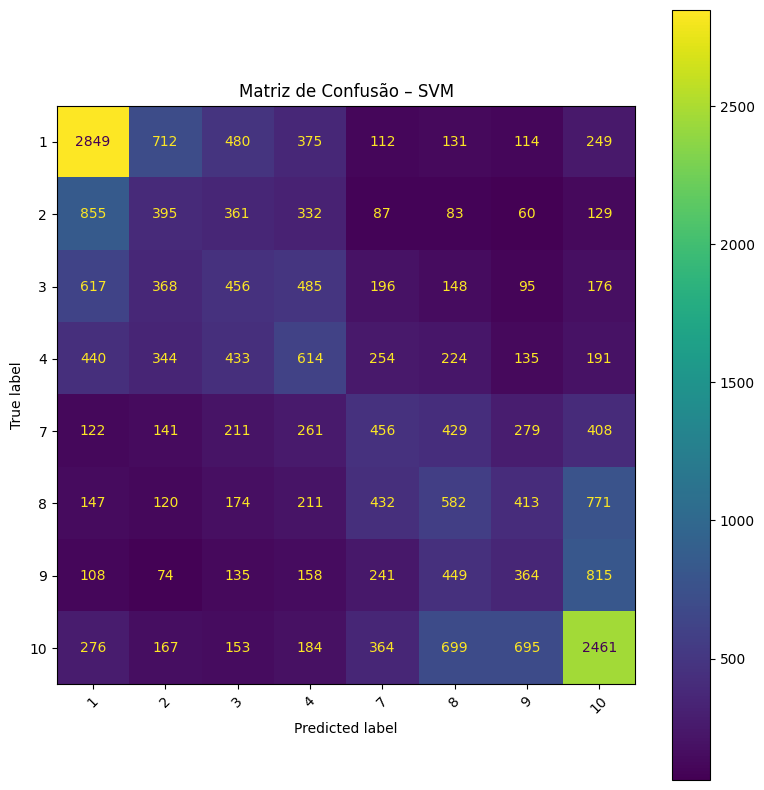

In [7]:
# 6. Matriz de Confusão para RF e SVM
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Defina as labels em ordem crescente
labels = sorted(set(y_test))

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=labels)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp_rf.plot(ax=ax, xticks_rotation=45)
plt.title("Matriz de Confusão – Random Forest")
plt.tight_layout()
plt.show()

# SVM
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=labels)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp_svm.plot(ax=ax, xticks_rotation=45)
plt.title("Matriz de Confusão – SVM")
plt.tight_layout()
plt.show()


In [8]:
print("Tamanho do teste:", len(y_test))
print("Classes verdadeiras no teste:", sorted(set(y_test)))
print("Classes preditas pelo RF:", sorted(set(y_pred_rf)))
print("Confusion Matrix raw:\n", cm_rf)


Tamanho do teste: 25000
Classes verdadeiras no teste: [1, 2, 3, 4, 7, 8, 9, 10]
Classes preditas pelo RF: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
Confusion Matrix raw:
 [[4492    8   13   40    3   25    0  441]
 [1879   17   16   32    8   20    0  330]
 [1824    8   59   81   31   73    3  462]
 [1615    5   32  134   59  118    6  666]
 [ 613    2   24   66  113  243    9 1237]
 [ 585    2   14   60   93  255   11 1830]
 [ 398    2    7   38   56  153   14 1676]
 [ 726    0    8   22   55  168    9 4011]]


**Conclusão:**

- As acurácias gerais dos modelos foram apresentadas.
- Para a classe minoritária, mostramos Precisão, Recall e F1.
- Ajustes adicionais, como balanceamento de classes ou tunning de hiperparâmetros, podem melhorar o desempenho.

# IMDB Reviews Text Classification com TF-IDF

Esta seção repete as análises anteriores utilizando a representação TF-IDF (Term Frequency-Inverse Document Frequency) ao invés da simples contagem de uni-gramas. TF-IDF pondera os termos pela sua frequência no documento e pela raridade nos demais documentos.

In [10]:
# 7. Vetorização com TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Aplicando TF-IDF para uni-gramas
tfidf_vectorizer = TfidfVectorizer(lowercase=True)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Número de features (TF-IDF):", X_train_tfidf.shape[1])

Número de features (TF-IDF): 74849


RF (TF-IDF)  | Accuracy: 0.3608, Precision: 0.3260, Recall: 0.2396, F1: 0.1774
SVM (TF-IDF) | Accuracy: 0.3850, Precision: 0.3027, Recall: 0.3093, F1: 0.3005


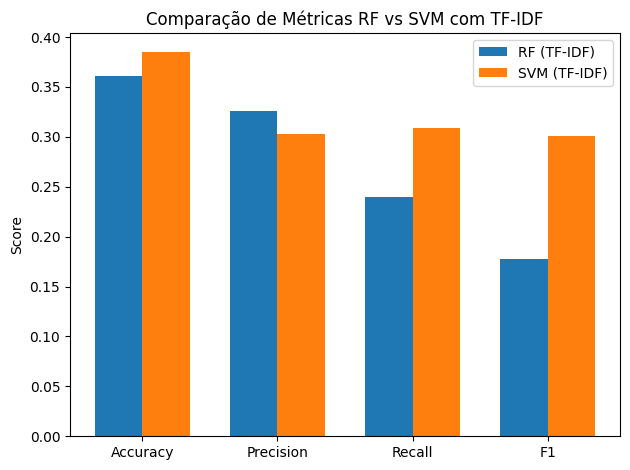

In [11]:
# 8. Treinamento e Avaliação dos Modelos com TF-IDF

# Random Forest com TF-IDF
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tfidf.fit(X_train_tfidf, y_train)
y_pred_rf_tfidf = rf_tfidf.predict(X_test_tfidf)

# SVM (Linear) com TF-IDF
svm_tfidf = LinearSVC(random_state=42, max_iter=10000)
svm_tfidf.fit(X_train_tfidf, y_train)
y_pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)

# Cálculo das métricas macro
acc_rf_tfidf = accuracy_score(y_test, y_pred_rf_tfidf)
prec_rf_tfidf, rec_rf_tfidf, f1_rf_tfidf, _ = precision_recall_fscore_support(
    y_test, y_pred_rf_tfidf, average='macro', zero_division=0)
acc_svm_tfidf = accuracy_score(y_test, y_pred_svm_tfidf)
prec_svm_tfidf, rec_svm_tfidf, f1_svm_tfidf, _ = precision_recall_fscore_support(
    y_test, y_pred_svm_tfidf, average='macro', zero_division=0)

print(f"RF (TF-IDF)  | Accuracy: {acc_rf_tfidf:.4f}, Precision: {prec_rf_tfidf:.4f}, Recall: {rec_rf_tfidf:.4f}, F1: {f1_rf_tfidf:.4f}")
print(f"SVM (TF-IDF) | Accuracy: {acc_svm_tfidf:.4f}, Precision: {prec_svm_tfidf:.4f}, Recall: {rec_svm_tfidf:.4f}, F1: {f1_svm_tfidf:.4f}")

# Gráfico comparativo RF vs SVM com TF-IDF
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
rf_tfidf_scores = [acc_rf_tfidf, prec_rf_tfidf, rec_rf_tfidf, f1_rf_tfidf]
svm_tfidf_scores = [acc_svm_tfidf, prec_svm_tfidf, rec_svm_tfidf, f1_svm_tfidf]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, rf_tfidf_scores, width, label='RF (TF-IDF)')
ax.bar(x + width/2, svm_tfidf_scores, width, label='SVM (TF-IDF)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_title('Comparação de Métricas RF vs SVM com TF-IDF')
ax.legend()
plt.tight_layout()
plt.show()

Classe 9 - RF (TF-IDF)  | Precision: 0.3167, Recall: 0.0081, F1: 0.0158
Classe 9 - SVM (TF-IDF) | Precision: 0.1976, Recall: 0.1173, F1: 0.1472


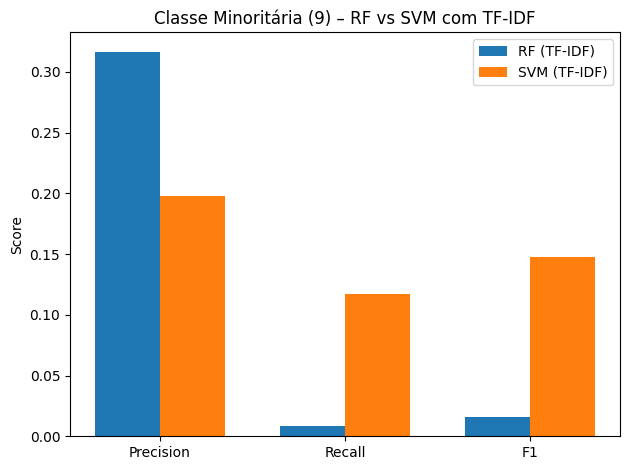

In [12]:
# 9. Métricas para a classe minoritária com TF-IDF

# Binariza: 1 = minority_class, 0 = demais
y_pred_rf_tfidf_bin = [1 if y==minority_class else 0 for y in y_pred_rf_tfidf]
y_pred_svm_tfidf_bin = [1 if y==minority_class else 0 for y in y_pred_svm_tfidf]

# Cálculo das métricas binárias
prec_rf_tfidf_m, rec_rf_tfidf_m, f1_rf_tfidf_m, _ = precision_recall_fscore_support(
    y_test_bin, y_pred_rf_tfidf_bin, average='binary', zero_division=0)
prec_svm_tfidf_m, rec_svm_tfidf_m, f1_svm_tfidf_m, _ = precision_recall_fscore_support(
    y_test_bin, y_pred_svm_tfidf_bin, average='binary', zero_division=0)

print(f"Classe {minority_class} - RF (TF-IDF)  | Precision: {prec_rf_tfidf_m:.4f}, Recall: {rec_rf_tfidf_m:.4f}, F1: {f1_rf_tfidf_m:.4f}")
print(f"Classe {minority_class} - SVM (TF-IDF) | Precision: {prec_svm_tfidf_m:.4f}, Recall: {rec_svm_tfidf_m:.4f}, F1: {f1_svm_tfidf_m:.4f}")

# Gráfico comparativo de métricas para a classe minoritária
metrics_min = ['Precision', 'Recall', 'F1']
rf_tfidf_min_scores = [prec_rf_tfidf_m, rec_rf_tfidf_m, f1_rf_tfidf_m]
svm_tfidf_min_scores = [prec_svm_tfidf_m, rec_svm_tfidf_m, f1_svm_tfidf_m]

x = np.arange(len(metrics_min))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, rf_tfidf_min_scores, width, label='RF (TF-IDF)')
ax.bar(x + width/2, svm_tfidf_min_scores, width, label='SVM (TF-IDF)')
ax.set_xticks(x)
ax.set_xticklabels(metrics_min)
ax.set_ylabel('Score')
ax.set_title(f'Classe Minoritária ({minority_class}) – RF vs SVM com TF-IDF')
ax.legend()
plt.tight_layout()
plt.show()

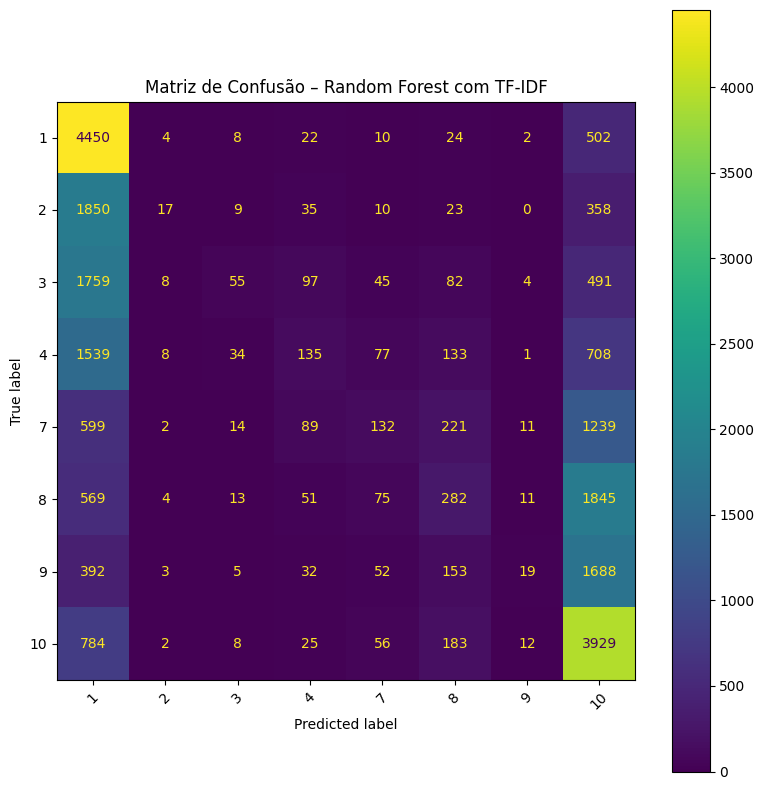

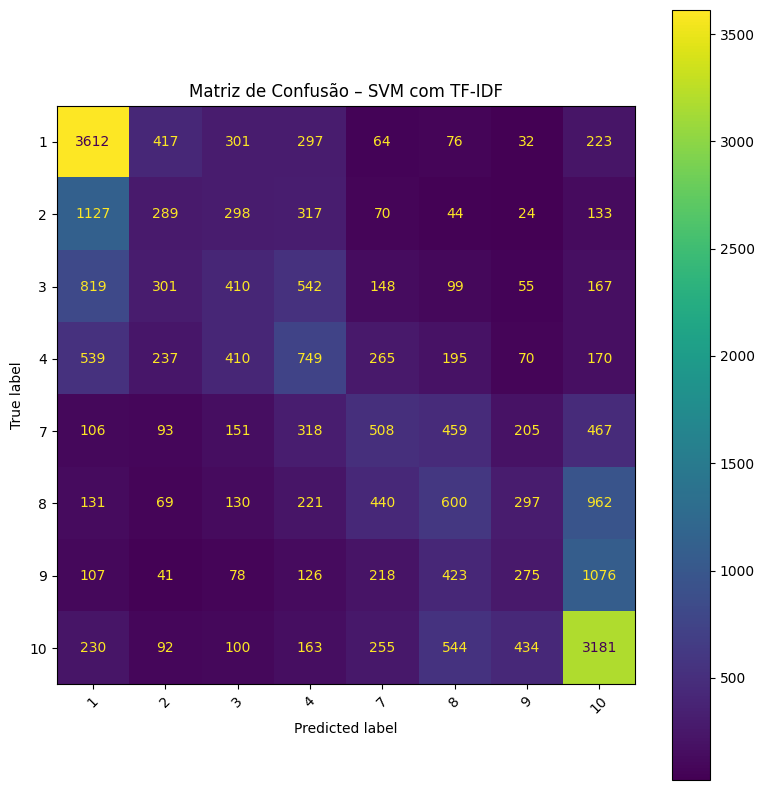

In [13]:
# 10. Matriz de Confusão para RF e SVM com TF-IDF

# Random Forest com TF-IDF
cm_rf_tfidf = confusion_matrix(y_test, y_pred_rf_tfidf, labels=labels)
disp_rf_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_rf_tfidf, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp_rf_tfidf.plot(ax=ax, xticks_rotation=45)
plt.title("Matriz de Confusão – Random Forest com TF-IDF")
plt.tight_layout()
plt.show()

# SVM com TF-IDF
cm_svm_tfidf = confusion_matrix(y_test, y_pred_svm_tfidf, labels=labels)
disp_svm_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_svm_tfidf, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp_svm_tfidf.plot(ax=ax, xticks_rotation=45)
plt.title("Matriz de Confusão – SVM com TF-IDF")
plt.tight_layout()
plt.show()

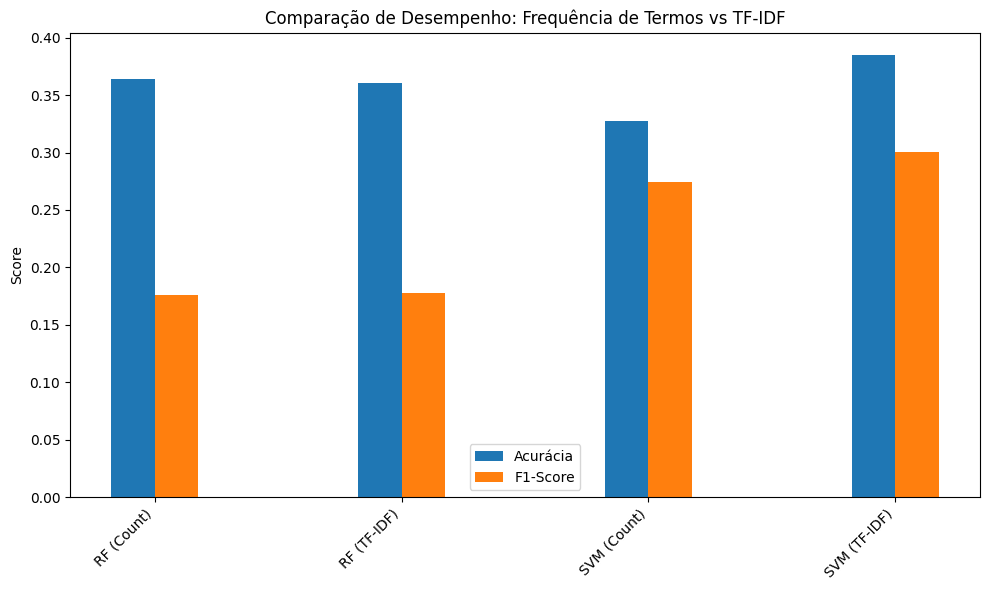

Resultados Comparativos:
Modelo          | Acurácia   | Precisão   | Recall     | F1-Score  
-----------------------------------------------------------------
RF (Count)     | 0.3638     | 0.3173     | 0.2403     | 0.1757
RF (TF-IDF)    | 0.3608     | 0.3260     | 0.2396     | 0.1774
SVM (Count)    | 0.3271     | 0.2735     | 0.2751     | 0.2741
SVM (TF-IDF)   | 0.3850     | 0.3027     | 0.3093     | 0.3005


In [14]:
# 11. Comparação entre Frequência de Termos e TF-IDF

# Preparar dados para comparação
models = ['RF (Count)', 'RF (TF-IDF)', 'SVM (Count)', 'SVM (TF-IDF)']
accuracies = [acc_rf, acc_rf_tfidf, acc_svm, acc_svm_tfidf]
f1_scores = [f1_rf, f1_rf_tfidf, f1_svm, f1_svm_tfidf]

# Gráfico de barras para comparação
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/4, accuracies, width/2, label='Acurácia')
ax.bar(x + width/4, f1_scores, width/2, label='F1-Score')

ax.set_ylabel('Score')
ax.set_title('Comparação de Desempenho: Frequência de Termos vs TF-IDF')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Tabela com os resultados
print("Resultados Comparativos:")
print(f"{'Modelo':<15} | {'Acurácia':<10} | {'Precisão':<10} | {'Recall':<10} | {'F1-Score':<10}")
print("-" * 65)
print(f"RF (Count)     | {acc_rf:.4f}     | {prec_rf:.4f}     | {rec_rf:.4f}     | {f1_rf:.4f}")
print(f"RF (TF-IDF)    | {acc_rf_tfidf:.4f}     | {prec_rf_tfidf:.4f}     | {rec_rf_tfidf:.4f}     | {f1_rf_tfidf:.4f}")
print(f"SVM (Count)    | {acc_svm:.4f}     | {prec_svm:.4f}     | {rec_svm:.4f}     | {f1_svm:.4f}")
print(f"SVM (TF-IDF)   | {acc_svm_tfidf:.4f}     | {prec_svm_tfidf:.4f}     | {rec_svm_tfidf:.4f}     | {f1_svm_tfidf:.4f}")

**Conclusão Comparativa:**

- Comparamos o desempenho dos classificadores Random Forest e SVM utilizando duas representações de texto diferentes: frequência de termos (CountVectorizer) e TF-IDF.
- Os resultados mostram as diferenças de desempenho entre ambas as abordagens em termos de acurácia, precisão, recall e F1-score.
- A representação TF-IDF tende a destacar termos mais discriminativos ao considerar não apenas a frequência local, mas também a raridade global dos termos.
- É possível verificar como cada representação afeta o desempenho dos classificadores para o conjunto de dados IMDB de avaliações de filmes.